In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import asc, desc

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.

# Querying the DB
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Unpacking the result
last_date = [last_date[0] for _ in last_date]

# Converting date to string
last_date = str(last_date[0])

print(f'The last measurement date is: {last_date}')

The last measurement date is: 2017-08-23


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Determining if there is a leap-year

# Converting last_date to datetime object
last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')

year = last_date.year
month = last_date.month

# Depending on the month of the measure I need to determine if leap-year calculations are done on the current or previous year
if month < 3:
    year -=1

# Leap-year computing
leap = False
if last_date.year % 4 == 0 and \
(last_date.year % 100 != 0 or last_date.year % 400 == 0):
    leap = True

days = 365
if leap == True:
    days = 366

# Obtaining starting date
first_date = last_date - dt.timedelta(days=days)

print (f'The date range is from {first_date} to {last_date}')


The date range is from 2016-08-23 00:00:00 to 2017-08-23 00:00:00


<AxesSubplot:title={'center':'Precipitation for the last 12 months'}, xlabel='Date'>

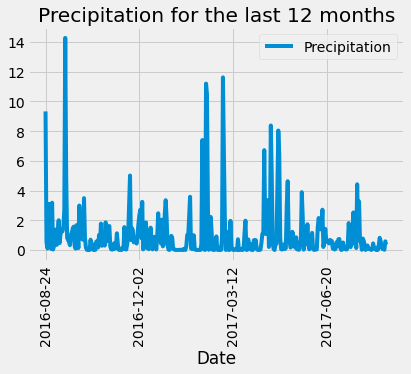

In [12]:
# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, func.sum(Measurement.prcp))\
.group_by(Measurement.date)\
.filter(Measurement.date >= first_date)\
.filter(Measurement.date <= last_date)\

# Save the query results as a Pandas DataFrame and set the index to the date column
prec_df = pd.DataFrame(precipitation, columns = ['Date', 'Precipitation'])
prec_df['Date'] = prec_df['Date'].astype(str)
prec_df.set_index('Date', drop = True, inplace= True)
prec_df = prec_df.dropna()

# Sort the dataframe by date
prec_df = prec_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
prec_df.plot(title= 'Precipitation for the last 12 months', rot = 90)


In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
prec_df.describe()



,Precipitation
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(func.count(Measurement.station.distinct()))
for row in stations:
    print(f'There are {row[0]} distinct stations')

There are 9 distinct stations


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.

active_sta = session.query(Measurement.station, func.count(Measurement.date).label('count'))\
.group_by(Measurement.station)\
.order_by(desc('count'))

for row in active_sta:
    print (row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Saving the id of the most active station
first_station = active_sta[0][0]

first_station

stats = session.query(Measurement.station,
                      func.max(Measurement.tobs),
                      func.min(Measurement.tobs),
                      func.avg(Measurement.tobs))\
.group_by(Measurement.station).filter(Measurement.station == first_station)

print (f'for the station {stats[0][0]}the max temperature is {stats[0][1]}, the minimum is {stats[0][2]} and the average is {stats[0][3]}')

for the station USC00519281 the max temperature is 85.0, the minimum is 54.0 and the average is 71.66378066378067


In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


SELECT measurement.station AS measurement_station, max(measurement.tobs) AS max_1, min(measurement.tobs) AS min_1, mean(measurement.tobs) AS mean_1 
FROM measurement 
WHERE measurement.station = ? GROUP BY measurement.station


# Close session

In [ ]:
# Close Session
session.close()